In [2]:
import boto3
import os
from dotenv import load_dotenv

load_dotenv()
access_key_id = os.getenv("ACCESS_KEY_ID")
secret_access_key = os.getenv("SECRET_ACCESS_KEY")
minio_url = "http://" + os.getenv("S3_API_ENDPOINT")


minio_client = boto3.client(
    "s3",
    aws_access_key_id=access_key_id,
    aws_secret_access_key=secret_access_key,
    endpoint_url=minio_url
)

minio_bucket = "training-preparation-zone"
manifest_name = "dataset_train.json"
local_file = "./dataset_train.json"

In [3]:
def download_manifest_from_minio(bucket_name, object_name, local_path):
    try:
        minio_client.download_file(bucket_name, object_name, local_path)
    except Exception as e:
        print(f"Error downloading {object_name} from bucket {bucket_name}: {e}")
    return local_path

downloaded_path = download_manifest_from_minio(minio_bucket, manifest_name, local_file)

In [4]:
import pandas as pd

def load_manifest(manifest_path):
    with open(manifest_path, 'r') as f:
        data = pd.read_json(f)
    
    print(f"Loaded {len(data)} entries from the manifest.")
    return data

df = load_manifest(downloaded_path)
print(df)

Loaded 415 entries from the manifest.
                       image                                     text  \
0    images/ISIC_0027249.png        texts/actinic_keratosis_0_0_0.txt   
1    images/ISIC_0027058.png        texts/actinic_keratosis_0_0_1.txt   
2    images/ISIC_0026152.png        texts/actinic_keratosis_0_0_2.txt   
3    images/ISIC_0026803.png        texts/actinic_keratosis_0_0_3.txt   
4    images/ISIC_0026077.png        texts/actinic_keratosis_0_0_4.txt   
..                       ...                                      ...   
410  images/ISIC_0027710.png  texts/squamous_cell_carcinoma_0_0_2.txt   
411  images/ISIC_0031380.png  texts/squamous_cell_carcinoma_0_0_3.txt   
412  images/ISIC_0032110.png  texts/squamous_cell_carcinoma_0_0_4.txt   
413  images/ISIC_0032110.png  texts/squamous_cell_carcinoma_0_0_5.txt   
414  images/ISIC_0034222.png  texts/squamous_cell_carcinoma_0_0_6.txt   

        score  
0    1.438926  
1    1.429278  
2    1.461677  
3    1.439080  
4    

## Hyperparameters

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from torch.optim import AdamW
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_ID = "openai/clip-vit-base-patch32"
BATCH_SIZE = 8
LEARNING_RATE = 5e-6
EPOCHS = 3

/home/oriol/Documentos/MDS/ADSDB/Part2/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data retrieval

The inputs variable is defined as it is because the model needs all of those parameters:

- Truncation=True means that if we provide more than 77 tokens (the usual maximum) it truncates the data

- Padding=max_length means that we add zeros to fill the max_length. We need to provide the same length for all the data (specially in text).



In [6]:
import io

class SkinLesionDataset(Dataset):
    def __init__(self, dataframe, processor, minio_client, bucket_name):
        self.df = dataframe
        self.processor = processor
        self.minio_client = minio_client
        self.bucket_name = bucket_name

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_key = self.df.iloc[idx]['image']
        txt_key = self.df.iloc[idx]['text']

        img_response = self.minio_client.get_object(Bucket=self.bucket_name, Key=img_key)
        img_bytes = img_response['Body'].read()
        image = Image.open(io.BytesIO(img_bytes)).convert("RGB")

        txt_response = self.minio_client.get_object(Bucket=self.bucket_name, Key=txt_key)
        description = txt_response['Body'].read().decode('utf-8').strip()

        inputs = self.processor(
            text=[description], 
            images=image, 
            return_tensors="pt", 
            padding="max_length", 
            truncation=True
        )
        
        return {k: v.squeeze(0) for k, v in inputs.items()}


## Initialization

Here we train the smaller clip model. We load it from the SkinLesionDataset class we created and the particularity is that we use AdamW. The AdamW is a widely used optimitzer for training Transformers. While the loss function tells the model where it needs to go, the optimitzer decides how fast to turn the wheel and step on the gas.

In [7]:
model = CLIPModel.from_pretrained(MODEL_ID).to(DEVICE)
processor = CLIPProcessor.from_pretrained(MODEL_ID)
dataset = SkinLesionDataset(df, processor, minio_client, minio_bucket)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [8]:
loss_history = []
model.train()

for epoch in range(EPOCHS):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}")
    epoch_loss = 0
    
    for batch in pbar:
        optimizer.zero_grad()
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        
        outputs = model(
            input_ids=batch['input_ids'],
            pixel_values=batch['pixel_values'],
            attention_mask=batch['attention_mask'],
            return_loss=True
        )
        
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        pbar.set_postfix({"loss": loss.item()})
    
    loss_history.append(epoch_loss / len(dataloader))

Epoch 3: 100%|██████████| 52/52 [02:03<00:00,  2.37s/it, loss=0.688]


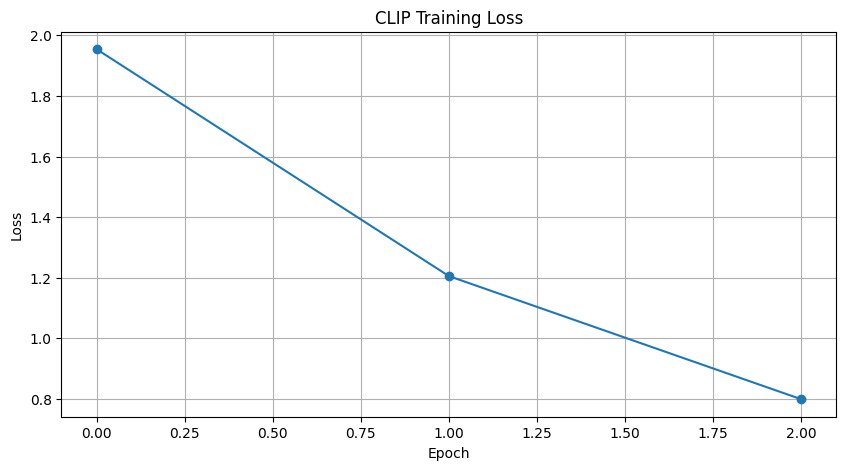

In [10]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(loss_history, marker='o')
plt.title("CLIP Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()